# Optimizing Neural Networks

To remind, necessary ingredients to train NN:
    * model
    * objective
    * optimizer
    
Today we will try to understand basics of optimization of neural networks, giving context for the last two lectures. Goal is to:
* Understand basics of generalization, and the difference between optimization and generalization (more on that in "Understanding generalization" lab)
* Understand impact of hyperparameters in SGD on:

  - stability (lr)
  - generalization (lr, batch size) <- next lab
  - speed of optimization (lr, momentum, batch size) <- next lab
  - gradients fidelity (batch size)

Note:
* There is a minor change in grading - now both numerical and textual answers are expected to be saved to files, details in exercise. Sorry for the change, will make it easier to grade.

References:
* Deep Learning book chapter on optimization: http://www.deeplearningbook.org/contents/optimization.html

# Setup

In [3]:
# Boilerplate code to get started

%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import linalg as LA
import tqdm
import json

import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch import optim

from keras.datasets import fashion_mnist
from keras.utils import np_utils

%matplotlib inline
import matplotlib.pylab as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

# Get FashionMNIST (see 1b_FMNIST.ipynb for data exploration)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Logistic regression needs 2D data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 0-1 normalization
x_train = x_train / 255.
x_test = x_test / 255.

# Binary case
ids_train = ((y_train==0) | (y_train==6))
ids_test = (y_test==0) | (y_test==6)
x_train_06 = x_train[ids_train]
y_train_06 = (y_train[ids_train] == 6).astype("float")
x_test_06 = x_test[ids_test]
y_test_06 = (y_test[ids_test] == 6).astype("float")

# Convert to Torch Tensor. Just to avoid boilerplate code later
x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)
x_train_06 = torch.from_numpy(x_train_06).type(torch.FloatTensor)
x_test_06 = torch.from_numpy(x_test_06).type(torch.FloatTensor)
y_train_06 = torch.from_numpy(y_train_06).type(torch.FloatTensor)
y_test_06 = torch.from_numpy(y_test_06).type(torch.FloatTensor)

# Use only first 1k examples. Just for notebook to run faster
x_train, y_train = x_train[0:1000], y_train[0:1000]
x_test, y_test = x_test[0:1000], y_test[0:1000]
x_train_06, y_train_06 = x_train_06[0:1000], y_train_06[0:1000]
x_test_06, y_test_06 = x_test_06[0:1000], y_test_06[0:1000]

Using Theano backend.


In [5]:
# Training loop adapted from 4_computing_gradient.ipynb

def build_mlp(input_dim, output_dim, hidden_dim=512):
    model = torch.nn.Sequential()
    model.add_module("linear_1", torch.nn.Linear(input_dim, hidden_dim, bias=True))
    model.add_module("nonlinearity_1", torch.nn.ReLU())
    model.add_module("linear_2", torch.nn.Linear(hidden_dim, output_dim, bias=True))
    return model

def build_logreg(input_dim, output_dim, hidden_dim=512):
    model = torch.nn.Sequential()
    model.add_module("linear_2", torch.nn.Linear(input_dim, output_dim, bias=True))
    model.add_module("nonlinearity_1", torch.nn.Softmax())
    return model

def build_linreg(input_dim, output_dim, hidden_dim=512):
    model = torch.nn.Sequential()
    model.add_module("linear_2", torch.nn.Linear(input_dim, output_dim, bias=True))
    return model

def step(model, loss, optimizer, x_val, y_val):
    x = Variable(x_val, requires_grad=False)
    y = Variable(y_val, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    output = loss.forward(fx, y)

    # Backward
    output.backward(retain_graph=True)

    # Update parameters
    optimizer.step()

    return output.data[0]

def predict(model, x_val):
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x).data.numpy()

    if output.shape[1] >= 2:
        return output.argmax(axis=1)
    else:
        return (output > 0.5).reshape(-1,)

def train(model, loss, optim, 
          x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, batch_size=100):
    """
    Trains given model on the FashionMNIST dataset.
    
    Returns
    -------
    history: dict
        History containing 'acc' and 'test_acc' keys.
    """
    torch.manual_seed(42) 
    n_examples, n_features = x_train.size()
    history = {"acc": [], "test_acc": []}
    for i in tqdm.tqdm(range(100), total=100):
        cost = 0.
        num_batches = n_examples // batch_size
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            cost += step(model, loss, optim, x_train[start:end], y_train[start:end])
        
        predY = predict(model, x_test)
        test_acc = np.mean(predY == y_test.numpy())
        history['test_acc'].append(test_acc)
 
        # Usually it is computed from per batch averages, but I compute
        # here using the whole train set to reduce level of noise in the learning curves
        predY = predict(model, x_train)
        train_acc = np.mean(predY == y_train.numpy())
        history['acc'].append(train_acc)
        
    return history

In [6]:
def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

# Generalization 101: learning curves and the bias/variance decomposition

To talk about optimization, it is important to understand the difference between optimization and generalization.

Optimization is sort-of easy, in the sense it is much more important to generalize than to optimize (but the two co-incide in SGD, optimization gives usually good generalization):

<img width=300 src="fig/7/overfittingspiral.png">

## Learning curves

100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


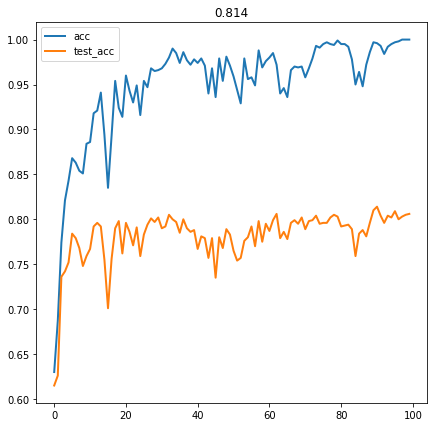

In [41]:
model = build_mlp(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H = train(loss=loss, model=model, optim=optimizer)
plot(H)

## Bias-variance

One way to understand generalization in machine learnning is through the bias-variance tradeoff. Other ways will be discussed next time.

<img width=200 src="fig/7/bias-and-variance.jpg">

<img width=600 src="fig/7/bias-and-variance2.png">

<p>
<font size=4>
$$E[(y - \hat{f(x)})^2] = Bias[\hat{f(x)}]^2 + Var[\hat{f(x)}] + \sigma^2$$, where

$$Bias[f(x)] = E[\hat{f(x)} - f(x)], Var[\hat{f(x)}] = E[(\hat{f(x)} - E[\hat{f(x)}])^2]$$
</font>
</p>

Reference:

https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff

## Exercise 1

Train 10 different logistic regressions and MLPs (hidden_dim=100) using the same optimization hyperparameters. Answer the following questions:
    
a) Which model achieves the lowest test error? What is the mean test accuracy of the MLP vs logistic regression?

b) Calculate (using the equation above) variance of MLP and Logreg. Which has the higher variance? 

c) If MLP has the higher variance, how is it possible that it achieves a lower test set error?

Additionally: plot (in the notebook) train accuracy curves for all the runs.

Please, save answers to json (as in the next cell). Do not change name of the json file.

Hint:
    * Use torch.manual_seed(seed) to set seed for each repetition
    * A very similar question might appear in the exam

In [59]:
answers = {"a": "", "b": "", "c": ""}
json.dump(answers, open("7_ex1.json", "w"))

# SGD(M) hyperparameters

SGD(M) hyperparameters impact:

* (Simple, this lab) Stability of training (lr)
* (Simple, this lab) Gradient accuracy (batch size)
* (Next lab) Speed of optimization (lr, momentum, batch size)
* (Next lab) Generalization (lr, batch size)

## Theory (stability, $\eta$)

Let's focus first on the fact that we cannot use larger $\eta$ than curvature. It is best visible in linear regression.

<img width=300 src="fig/7/overshoot_4.png">


## Theory ($\eta$ and $S$)

<p>
<font size=4>
Notation: $\eta$ - learning rate, $S$ - batch size
</font>
</p>


<p>
<font size=4>
For small $\eta$:
$$d\theta = -g(\theta)dt + \sqrt{\frac{\eta}{S} C(\theta) dW(t)},$$

from which we can see that $\eta$ and $S$ have similar impact on noise in SGD. A similar argument can be made for momentum.
</font>
</p>

## Exercise 2: impact of $\eta$ on stability

Find largest learning rate that optimizes (can cause small oscillations) in linear regression. Compare it to the theoretical prediction: inverse of the spectral norm of the loss surface in linear regression.

Hint: 
* Hessian in linear regression is H = 1/n X^T X 
* LA.eig(A) computes eigenvalues 

In [90]:
def get_linreg_curvature(x_train):
    ??

C = get_linreg_curvature(x_train_06.numpy())
model = build_linreg(784, 1)
loss = torch.nn.MSELoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.0)
H = train(loss=loss, model=model, optim=optimizer, x_train=x_train_06, x_test=x_test_06,
         y_train=y_train_06, y_test=y_test_06, batch_size=len(x_train_06))
plot(H)

Object `` not found.


In [ ]:
# 1/spectral_norm is the inverse of maximum eigenvalue
answers = {"maximum_lr": 0, "1/spectral_norm": 0}
json.dump(answers, open("7_ex2.json", "w"))

## Exercise 3: impact of BS on gradient fidelity

For different BS compare fidelity defined as:

* fidelity = $\langle g, \hat g \rangle$ 

Plot and save figure:
* 7_ex3a.png: X axis is BS in range, Y axis is fidelity averaged over 50 samples.

Expected outcome is shown below. Starting code is provided.

<img width=300 src="fig/7/ex3_expected.png">

Hints:
* Re-use step function code
* You can use gradient wrt to just one weight matrix
* You can access weight matrices using model.named_parameters
* Remember to normalize the cosine product
* When returning gradient, copy matrix (.copy()) to avoid using references

Note:
* Exam might have questions about interpretation of these plots.

In [97]:
model = build_mlp(784, 10)
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [ ]:
def sample_gradient(batch_size):
    # Returns vector of size D, where D is number of params in the network
    g = ??
    return g

def true_gradient():
    # Returns true gradient of size D, where D is number of params in the network 
    g = ??
    return g

100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Text(0,0.5,u'Fidelity')

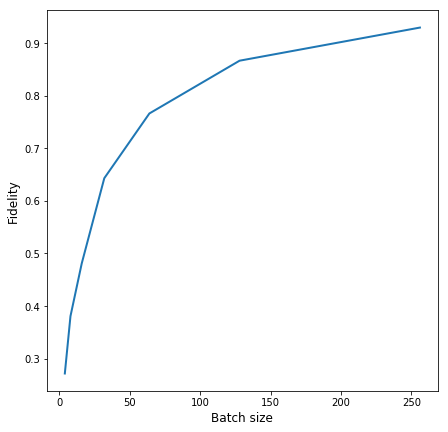

In [115]:
# Code assuming sample_gradient and true_gradient are implemented
fidelities = []
bss = [4, 8, 16, 32, 64, 128, 256]
for batch_size in tqdm.tqdm(bss, total=len(bss)):
    true_grad = true_gradient()
    fidelity = []
    for _ in range(50):
        g = sample_gradient(batch_size)
        # Note normalization
        fidelity.append(np.dot(g, true_grad)/(np.linalg.norm(g)*np.linalg.norm(true_grad)))
    fidelities.append(np.mean(fidelity))
plt.plot(bss, fidelities)
plt.xlabel("Batch size")
plt.ylabel("Fidelity")
plt.savefig("7a_ex3.png")

## Exercise 4: impact of hyperparameters on optimization speed

Probably next lab :)

## Exercise 5: impact of hyperparameters on generalization

Probably next lab :)